In [23]:
from music21 import *

автоматическая генерация музыки - это процесс создания небольшого музыкального произведения с минимальным вмешательством человека.

В 1787 году Моцарт предложил <b>игру в кости</b> для случайного выбора звука (и он был не первым и не последним - https://ru.wikipedia.org/wiki/Музыкальная_игра_в_кости). 
<br>
<br>
В начале 1950-х Яннис Ксенакис использовал концепции статистики и вероятности для создания музыки, получившей название <b>стохастическая музыка</b> https://algorithmiccomposition.ru/article_entry_xenakis.html. Базовая идея: музыка - последовательность звуков, которая возникает случайно. Значит, выбор этих звуков может строго зависеть от математического аппарата.
<br>
<br>
<b>Архитектуры глубокого обучения</b> стали "легким" решением в рамках задачи автоматической генерации музыки. Почему именно DL "выстрелил" в этой задаче? - ответ прост, потому что требуются универсальные функциональные аппроксиматоры, а это нейросетки.

<b>Составные элементы музыки</b>
<br><br>
Звук, производимый одной клавишей, называется <b>нотой</b>.<br>
Звук, воспроизводимый двумя или более клавишами одновременно, называется <b>аккордом</b>. Как правило, большинство аккордов содержат как минимум 3 ключевых звука.<br>
Повторяющийся базисный музыкальный интервал называется <b>октавой</b>. Каждая октава содержит 7 белых и 5 черных клавиш.

<h1>Подход 1: использование WaveNet</h1>
    <br>
<p>WaveNet - модель генерации необработанного звука, разработанная Google DeepMind - https://en.wikipedia.org/wiki/WaveNet. Основная цель WaveNet - генерировать новые выборки из исходного распределения данных. То есть перед нами генеративная модель, которая очень похожа на языковые модели.
<p>WaveNet принимает на входе кусок необработанной звуковой волны (которая представлена в виде значений амплитуды = временной ряд). <img src='http://ar.flashmode.tn/wp-content/uploads/2018/06/Shazam-Was-That-Song-Nickelback-Or-Pitbull.gif'>
    <br><br>
<p>Выход WaveNet:<br>
<img src='https://habrastorage.org/getpro/habr/post_images/2fe/b25/464/2feb25464260ad8a96c983bb85340fee.gif'>
    <br>
    На каждом шагу семплинга значение вычисляется из вероятностного распределения посчитанного сетью. Затем это значение возвращается на вход и делается новое предсказание для следующего шага.
    <br>
    То есть перед нами построение авторегрессионной модели, в которой каждый семпл зависит от всех предыдущих.
    <br><br>
    Еще мы видим, что перед нами сверточная нейронная сеть (https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/), где слои имеют разные факторы дилатации и позволяют ее рецептивному полю расти экспоненциально с глубиной и покрывать тысячи временных отрезков. 
    
<h1>Подход 2: использование модели долгой краткосрочной памяти (LSTM)</h1>
    <br>
<p> LSTM представляет собой вариант рекуррентных нейронных сетей (RNN) - https://ru.wikipedia.org/wiki/Долгая_краткосрочная_память, способна фиксировать долгосрочные зависимости во входной последовательности.
<p>При обучении условные вероятности во все моменты времени могут вычисляться
параллельно, потому что все значения сигнала x заранее известны. Во время генерации предсказания последовательны: каждая предсказанная точка подаётся обратно на вход нейросети, чтобы предсказать следующую.
    
<br><br>
 Подготовка входных и выходных последовательностей аналогична WaveNet. На каждом временном шаге значение амплитуды загружается в ячейку памяти - затем модель вычисляет скрытый вектор и передает его на следующий шаг. Текущий скрытый вектор на временном шаге вычисляется на основе текущего входного и ранее скрытого вектора.
 
<p>почитать подробнее про плюсы и минусы моделей: https://habr.com/ru/company/wunderfund/blog/331310/


# Реализация

In [25]:
# функция для чтения MIDI
# возвращает массив нот и аккордов, присутствующих в музыкальном файле

def read_midi(file):
    
    print("Загружаем файл:",file)
    
    notes=[]
    notes_to_parse = None
    
    # парсинг файла
    midi = converter.parse(file)
  
    # группировка по разным инструментам
    s2 = instrument.partitionByInstrument(midi)

    #перебор инструментов
    for part in s2.parts:
    
        notes_to_parse = part.recurse() 
      
        #определение: нота или аккорд
        for element in notes_to_parse:
                
            #нота
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                
            #аккорд
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [26]:
#загружаем файлы
import os
import numpy as np

path='samples/'

#читаем все файлы
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#изучаем midi
notes_array = np.array([read_midi(path+i) for i in files])

Загружаем файл: samples/midi_songs_d-123trainwithme.mid
Загружаем файл: samples/midi_songs_d-captainjack.mid
Загружаем файл: samples/schubert_sonata_157_2_(c)yogore.mid
Загружаем файл: samples/schubert_sonata_157_3_(c)yogore.mid


In [27]:
#2D массив в 1D 
notes_ = [element for note_ in notes_array for element in note_]

#Кол-во уникального
unique_notes = list(set(notes_))
print(len(unique_notes))

161


(array([115.,  22.,  10.,   3.,   6.,   1.,   0.,   1.,   1.,   2.]),
 array([  1. ,  77.4, 153.8, 230.2, 306.6, 383. , 459.4, 535.8, 612.2,
        688.6, 765. ]),
 <a list of 10 Patch objects>)

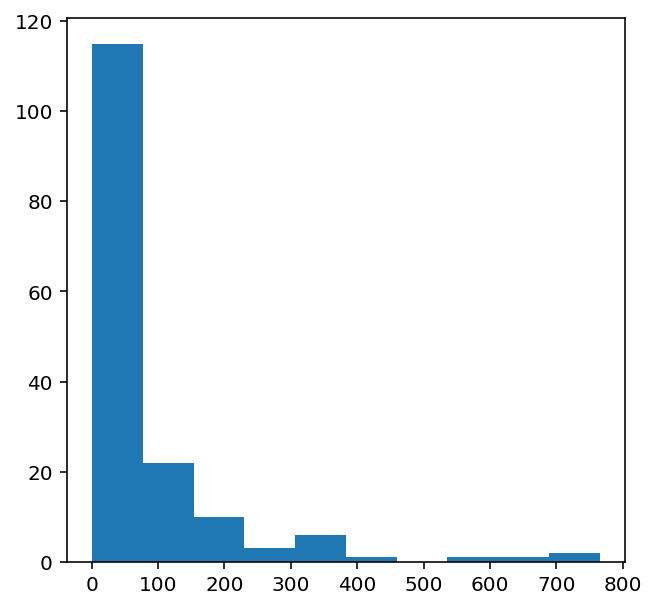

In [28]:
from collections import Counter
import matplotlib.pyplot as plt

#частота каждой ноты
freq = dict(Counter(notes_))

#рассматривать только частоты
no=[count for _,count in freq.items()]

plt.figure(figsize=(5,5))
plt.hist(no)

Из графика мы можем сделать вывод, что большинство нот имеют низкую частоту. Проигнорируем низкочастотные звуки. Например, поставим порог в 50. Тем не менее, параметр можно изменить.

In [29]:
frequent_notes = [note_ for note_, count in freq.items() if count>=25]
print(len(frequent_notes))

80


In [30]:
# подготовим новые музыкальные файлы, которые содержат только эти ноты.

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [31]:
# Подготовка входных и выходных последовательностей

no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [32]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [33]:
#входные последовательности
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        # каждой записи присваиваем уникальное целое число
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [34]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [35]:
# 80% данных для обучения, 20% для оценки:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [36]:
# Построение модели
def lstm():
    model = Sequential()
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

In [38]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           8000      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [39]:
# лучшая модель во время обучения
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [40]:
# Обучаем модель. размер батча 128, 50 эпох:

history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 3.4596
Epoch 00001: val_loss improved from inf to 3.00817, saving model to best_model.h5
74/74 [==============================] - 8s 104ms/step - loss: 3.4596 - val_loss: 3.0082
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 2.6738
Epoch 00002: val_loss improved from 3.00817 to 2.64150, saving model to best_model.h5
74/74 [==============================] - 8s 107ms/step - loss: 2.6738 - val_loss: 2.6415
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 2.4429
Epoch 00003: val_loss improved from 2.64150 to 2.46067, saving model to best_model.h5
74/74 [==============================] - 8s 102ms/step - loss: 2.4429 - val_loss: 2.4607
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 2.2467
Epoch 00004: val_loss improved from 2.46067 to 2.27187, saving model to best_model.h5
74/74 [==============================] - 7s 97ms/step - loss: 2.2467 - val_loss: 2.2719
Epoch

73/74 [============================>.] - ETA: 0s - loss: 0.6832
Epoch 00034: val_loss improved from 0.95508 to 0.94588, saving model to best_model.h5
74/74 [==============================] - 7s 91ms/step - loss: 0.6825 - val_loss: 0.9459
Epoch 35/50
73/74 [============================>.] - ETA: 0s - loss: 0.6640
Epoch 00035: val_loss improved from 0.94588 to 0.94578, saving model to best_model.h5
74/74 [==============================] - 7s 92ms/step - loss: 0.6637 - val_loss: 0.9458
Epoch 36/50
74/74 [==============================] - ETA: 0s - loss: 0.6608- ET
Epoch 00036: val_loss improved from 0.94578 to 0.92307, saving model to best_model.h5
74/74 [==============================] - 7s 95ms/step - loss: 0.6608 - val_loss: 0.9231
Epoch 37/50
74/74 [==============================] - ETA: 0s - loss: 0.6472
Epoch 00037: val_loss did not improve from 0.92307
74/74 [==============================] - 6s 82ms/step - loss: 0.6472 - val_loss: 0.9264
Epoch 38/50
73/74 [========================

In [41]:
#загрузка лучшей модели
from keras.models import load_model
model = load_model('best_model.h5')

In [42]:
# поехали сочинять: для прогнозов следуем шагам, указанным на этапе вывода.

import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(50):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[62, 55, 1, 67, 65, 2, 1, 19, 31, 18, 1, 57, 28, 31, 18, 31, 28, 1, 57, 18, 3, 28, 1, 54, 28, 3, 18, 1, 54, 28, 58, 79, 1, 21, 55, 58, 79, 58, 55, 1, 21, 79, 62, 55, 1, 67, 65, 2, 1, 19]


In [43]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [44]:
# обратное преобразование прогнозов в файл MIDI

def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # объекты нот и аккордов на основе значений, сгенерированных моделью
    for pattern in prediction_output:
        
        # аккорд
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # нота
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # увеличиваем смещение на каждой итерации, чтобы ноты не слипались
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [45]:
convert_to_midi(predicted_notes)